249 488
Text found: 220
Text bounding box: Top-left (64, 18), Bottom-right (100, 33)
Adjusted Bounding Box: Top-left (24, 12), Bottom-right (100, 33)
Rows cropped: 2


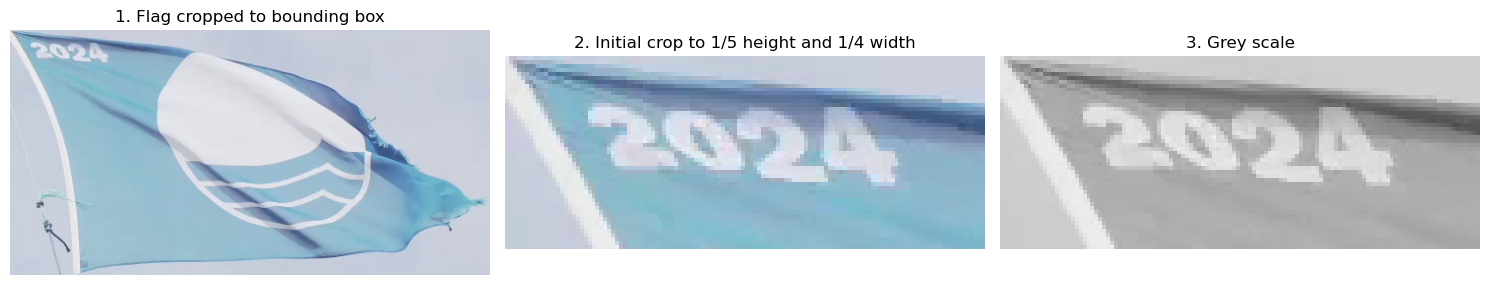

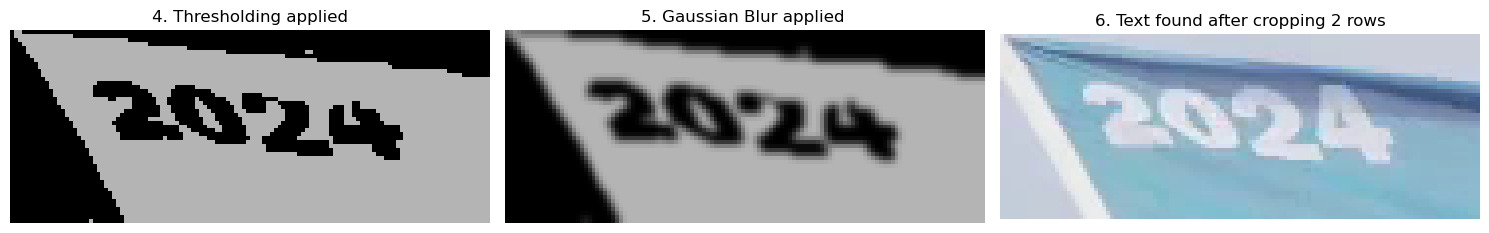

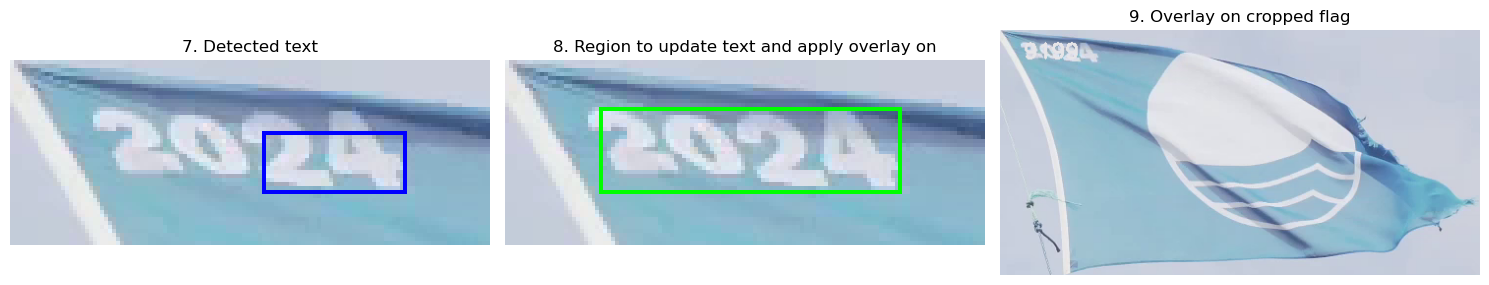

In [10]:
# Listing: OCR to display images based on - A_Aug_OCR_and_replace_Year_Flag_Text_Approach2.jpynb 
# Methodology to identify and replace text on an image (a cropped flag) using Tesseract OCR and OpenCV. 
# Process an input image (intended for a flag) to: 
#   - Locate and identify text 
#   - Define an overlay region around the detected text
#   - Replace detected text with text (e.g., "2026") on a background overlay.
#   - Blend the overlay with the surrounding image area.
#   - Save and display the modified image.
#   - Allow for adjustments for individual images to account for variability in

# locations of detected characters
# Take an input of a cropped flag - initial crop it (5th high/3rd wide) - search for text - overlay text on new overlay -
# Progressively crop the image by 1 row until text is / is not found ...
#  Initial Crop it to 1/5 of height and  1/3 width to localise to the area where the text is on the top left - for flags with text facing correctly 
#  Use Tesseract OCR to search for text - optimise for digits -  
#   If text is found 
#    Get the bounding box of the last character and convert OpenCV format -inverting ys
#    Define an overlay area - 
#    Apply nudge vaues that are user defined and specific to the image -
#     -this is to account for the variability in how the text position is extracted by Tesseract 
#     -The characters are not aligned etc and the challenge of detecting text on an outdoor suspended fabric flag in constant motion and not laid flat  
#   Sample colour from the bottom right of the ovrlay area 
#   Put text on the overlay etc. 
#   Apply overlay blending to blend the overlay into the area on which it is placed 
# 
# If text is not found, progressively crop 1 row from the bottom and repeat until text is or is not found ...
# This approach 2 uses the bounding box of the last character found during OCR detection should help align the overlay and replacement
# text more consistently, as it avoids variability caused by misaligned or distorted individual character positions.
# base the overlay patch and text alignment on the last detected character’s bounding box. 

import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
import os
import random

# Load the image
#filename = "frame_000025_flag_crop.PNG" # Good candidate overlay_left_nudge =   22overlay_top_nudge =    12  # Pad upwards overlay_right_nudge =  -22 overlay_bottom_nudge = 5 

filename = "croppedflag.png"
image_path_base=r"D:/FlagDetectionDatasets/a_pSDS/new"
#image_path_base=r'D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR_old_2/Cropped'

# Nudge values to expand or contract the coordinates of detected text
overlay_left_nudge =   - 40
overlay_top_nudge =    -  6   
overlay_right_nudge =  0  
overlay_bottom_nudge = 0 

#Good candidate
#overlay_left_nudge =   22
#overlay_top_nudge =    12  # Pad upwards 
#overlay_right_nudge =  -22 
#overlay_bottom_nudge = 5 

#filename ="frame_000690_flag_crop_2.jpg"
#image_path_base=r"D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/Cropped_BlueFlags"

# Nudge evalues 
#overlay_left_nudge = 24   # Nudge / Expand overlay to the left
#overlay_top_nudge =  16  # Shift overlay top 
#overlay_right_nudge =  - 20   # - overlay_left_nudge + 10 # Expand/Contract right edge  ##
#overlay_bottom_nudge =   0  # 5   # Slightly pad overlay to the bottom so that it covers text

#top_text_estimate = 20
image_path = os.path.join(image_path_base, filename)

# First image 
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")
# Copy 1 of original image  
image_ocr = image.copy()
# Constants and parameters
# replacement_text = "2026"
# String of random digits (e.g., 4 digits)
replacement_text = ''.join(random.choices('0123456789', k=4)) # Will be able to get text_size for Open CV 

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = .7
thickness = 2
text_color = (232, 229, 230)  # Off-white (B, G, R)
overlay_alpha = 0.8  # Transparency factor (0: transparent, 1: opaque

# get the height and width of the original image 
height, width = image.shape[:2]
print(height, width) 
cropFractionH = 5
cropFractionW = 4
cropped_height = int(height // cropFractionH)
cropped_width = int(width // cropFractionW)
# Crop initially to a fraction specified - e.g. 1/4 and 1/4 to get to the locaised area where the text should be 
cropped_img = image[:cropped_height, :cropped_width]

cropped_img_initial = cropped_img.copy() #Just to show initial crop 
# These are to demonstrate and display the intermediate results 
gray_initial = cv2.cvtColor(cropped_img_initial, cv2.COLOR_BGR2GRAY)
_, thresh_initial = cv2.threshold(gray_initial, 200, 180, cv2.THRESH_BINARY_INV)
blurred_initial = cv2.GaussianBlur(thresh_initial, (5, 5), 0)  
 
# Variables for OCR and positioning
text_found = False
updated_image = None
cropped_rows = 0
text_size = cv2.getTextSize(replacement_text, font, font_scale, thickness)[0]
text_width, text_height = text_size

# Generate a string of random digits (e.g., 4 digits)
replacement_text = ''.join(random.choices('0123456789', k=4)) # Will be able to get text_size for Open CV 
#print(f"Random replacement text: {replacement_text}")

# OCR Configration - choose engine automatically - character list - 
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'

detected_text_area = False

# Function to draw a bounding box 
def draw_debug_box(img, x1, y1, x2, y2, color=(0, 0, 255), label="Box"):
    """Draw a debug bounding box with a label at the top of the image."""
    # Draw the rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)
    # Align the label to the top of the image
    #top_label_y = max(2, 2)  # Fixed y-coordinate for the label near the top
    cv2.putText(img, label, (8, 8), font, 0.4, color, 1)

while cropped_height > 0:
    #print(f"Checking for text - Rows cropped {cropped_rows} ...  ")
    cropped_img = image[:cropped_height, :cropped_width] 
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    # Preprocessing to optimise for OCR   
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    # Threshold and blur
    _, thresh = cv2.threshold(gray, 200, 180, cv2.THRESH_BINARY_INV)
    blurred = cv2.GaussianBlur(thresh, (5, 5), 0)

    # DoOCR and bounding box calculations for the last detected character
    text = pytesseract.image_to_string(blurred, config=custom_config).strip()
    boxes = pytesseract.image_to_boxes(blurred, config=custom_config)
    h, w = blurred.shape  
    
    
    if text:
        text_found = True
        print(f"Text found: {text}")
        # Copy for showing crop where text detected - do nothing with this after  
        # print(f"Making copy of cropped_img2 in loop: {cropped_rows +1}")
        cropped_img2 = cropped_img.copy()
            
        # Use the last character bounding box
        last_box = boxes.splitlines()[-1].split()
        x1, y1, x2, y2 = (int(last_box[1]),h - int(last_box[2]),int(last_box[3]),h - int(last_box[4]),)

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        #for box in boxes.splitlines():
        #    b = box.split()
        #    # Coordinates each detected character
        #    x1, y1, x2, y2 = int(b[1]), h - int(b[2]), int(b[3]), h - int(b[4])  # Convert Tesseract to OpenCV
        #    print(f"Character: {b[0]}")
        #    print(f"  - Bounding box (OpenCV): Bottom-left: ({x1}, {y1}), Top-right: ({x2}, {y2})")
        #    # Calculate the combined bounding box that has all detected characters.
        #    #x1_combined = min(x1_combined, x1)
        #    #y1_combined = max(y1_combined, y1)
        #    #x2_combined = max(x2_combined, x2)
        #    #y2_combined = min(y2_combined, y2) 
            
        #    x1_combined = min(x1, x1)
        #    y1_combined = max(y1, y1)
        #    x2_combined = max(x2, x2)
        #    y2_combined = min(y2, y2) 
        #    #print(f"  - Bounding box (OpenCV): Bottom-left: ({x1}, {y1}), Top-right: ({x2}, {y2})")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@

        updated_image1 = cropped_img.copy()
        
        # Copy of cropped_img for text label 
        if text_found and not detected_text_area:
            updated_label = cropped_img.copy()
            # Show bounding box in cropped image
            draw_debug_box(updated_label, x1, y2, x2, y1, (255, 0, 0), " ") # Removed / Blank label / Detected Text Label
            detected_text_area = True

        # Adjust coordinates for the original image and apply image specific nudge values 
        overlay_left = max(0, x1) + overlay_left_nudge  
        overlay_top =  max(0, y2) + overlay_top_nudge    
        overlay_right = min(width, x2) + overlay_right_nudge  
        overlay_bottom = max(0, y1) + overlay_bottom_nudge
        #overlay_bottom = (overlay_top + text_height  + overlay_bottom_nudge)
                
        # Copy of cropped_img for text region 
        updated_image2 = cropped_img.copy()
        draw_debug_box(updated_image2, overlay_left, overlay_top, overlay_right, overlay_bottom, (0, 255, 0), "") #Removed label Region to update 
        
        # Debugging: Print adjusted coordinates
        print(f"Text bounding box: Top-left ({x1}, {y2}), "f"Bottom-right ({x2}, {y1})")
        print(f"Adjusted Bounding Box: Top-left ({overlay_left}, {overlay_top}), "f"Bottom-right ({overlay_right}, {overlay_bottom})")
    
        # Do stuff to the image 
        
        # Copy of cropped_img for making further changes 
        updated_image_out = cropped_img.copy()
        # Sample the background color from a region around the bounding box
        #sample_region = image_ocr[max(0, overlay_top - 2):min(height, overlay_bottom + 2),
        #                              max(0, overlay_left - 2):min(width, overlay_right + 2)]
       
        sample_region = image_ocr[max(0, overlay_top - 10):min(height, overlay_bottom + 10),
                                      max(0, overlay_left - 2):min(width, overlay_right + 2)]
      
        if sample_region.size > 0:
            background_color = np.mean(sample_region, axis=(0, 1)).astype(int).tolist()
        else:
            background_color = (0, 0, 0)  # Default to black if sampling fails
        
        # Create an overlay image and draw the background
        # Did expermiment with a featherd mask at this point but removed 
        overlay_ocr = image_ocr.copy()
        cv2.rectangle(overlay_ocr,(overlay_left, overlay_top),(overlay_right, overlay_bottom),background_color,-1)
        , overlay_bottom cv2.addWeighted(overlay_ocr, overlay_alpha, image_ocr, 1 - overlay_alpha, 0, image_ocr)

        # Align text within the overlay
        text_x = overlay_left  # Align text left
        text_y = overlay_top + text_height  # Center text vertically in the overlay

        #@@@@@@@@@@@@@@
        ## Space the text horizontally within the detected text bounding box 
        box_width =  overlay_right - overlay_left
        box_height = overlay_top - overlay_bottom
        # Calculate the spacing between each character to stretch the text
        char_spacing = box_width // len(replacement_text) 

        # Start drawing each character of the new text, spaced out to fill the bounding box
        #current_x = x1  # Start at the left boundary of the bounding box
        text_size = cv2.getTextSize(replacement_text, font, font_scale, thickness)[0]
        #text_x = x1  # Start the text at the left boundary of the bounding box
        #text_y = y1 - (y1 - y2 - text_size[1]) // 2  # Center the text vertically

        # Start drawing each character of the new text, spaced out to fill the bounding box
        current_x = overlay_left  # Start at the left boundary of the bounding box
        for char in replacement_text:
            # Vertical position to center the character within the bounding box
            char_y = overlay_bottom - (overlay_bottom - overlay_top - text_size[1]) // 2  # Center vertically 
            cv2.putText(image_ocr, char, (current_x, char_y), font, font_scale, text_color, thickness)
            # Move the current_x position for the next character, with the calculated spacing
            current_x += char_spacing

        #@@@@@@@@@@@@@@@@
        # Place replacement text
        cv2.putText(image_ocr, replacement_text, (text_x, text_y), font, font_scale, text_color, thickness)

        # Save the updated image for final display
        updated_image = image_ocr.copy()
        #print(f"Found on loop with cropped height {cropped_height}")
        break  # Stop cropping after finding text
    # Reduce crop height and retry
    cropped_height -= 1
    cropped_rows +=1

#else: # Adjust coordinates for the original image and apply image specific nudge values 
#print(f"No text found.")


# Save and display the results for debugging
output_path = f"D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/ocr_{filename}"

# Process the image until text is found or crop height is zero
print(f"Rows cropped: {cropped_rows}")
 
# Plots to show workings 
fig, axes = plt.subplots(1, 3, figsize=(15, 6))  # 1x2 grid
# original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].axis("off")
axes[0].set_title("1. Flag cropped to bounding box")     
# Plot the initial cropped image
axes[1].imshow(cv2.cvtColor(cropped_img_initial, cv2.COLOR_BGR2RGB))
axes[1].axis("off")
axes[1].set_title(f"2. Initial crop to 1/{cropFractionH} height and 1/{cropFractionW} width")

axes[2].imshow(cv2.cvtColor(gray_initial, cv2.COLOR_BGR2RGB))
axes[2].axis("off")
axes[2].set_title(f"3. Grey scale")
plt.tight_layout()
plt.show()

# Plots to show workings 
fig, axes1 = plt.subplots(1, 3, figsize=(15, 6))  # 1x2 grid
# original image
axes1[0].imshow(cv2.cvtColor(thresh_initial, cv2.COLOR_BGR2RGB))
axes1[0].axis("off")
axes1[0].set_title("4. Thresholding applied")  
# Plot the initial cropped image
axes1[1].imshow(cv2.cvtColor(blurred_initial, cv2.COLOR_BGR2RGB))
axes1[1].axis("off")
axes1[1].set_title(f"5. Gaussian Blur applied ")
axes1[2].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
axes1[2].axis("off")
axes1[2].set_title(f"6. Text found after cropping {cropped_rows} rows")
plt.tight_layout()
plt.show()

# Plots to show workings 
fig, axes2 = plt.subplots(1, 3, figsize=(15, 6))  # 1x2 grid
# original image
axes2[0].imshow(cv2.cvtColor(updated_label, cv2.COLOR_BGR2RGB))
axes2[0].axis("off")
axes2[0].set_title("7. Detected text")  

axes2[1].imshow(cv2.cvtColor(updated_image2, cv2.COLOR_BGR2RGB))
axes2[1].axis("off")
axes2[1].set_title("8. Region to update text and apply overlay on")

axes2[2].imshow(cv2.cvtColor(updated_image, cv2.COLOR_BGR2RGB))
axes2[2].axis("off")
axes2[2].set_title("9. Overlay on cropped flag")
plt.tight_layout()
plt.show()

#fig, axes1 = plt.subplots(1, 2, figsize=(15, 6))  # 1x2 grid

#axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#axes[1].axis("off")
#'axes[1].set_title(" ")
#plt.tight_layout()
#plt.show()

    
    #overlay_left = overlay_left_nudge  
    #overlay_top =  overlay_top_nudge    
    #overlay_right = overlay_right_nudge  
    #overlay_bottom = overlay_bottom_nudge
    #print(f"Bounding Box: Top-left ({overlay_left}, {overlay_top}), "f"Bottom-right ({overlay_right}, {overlay_bottom})")

    # Copy of cropped_img for text region 
    #updated_image2 = cropped_img.copy()
    #draw_debug_box(updated_image2, overlay_left, overlay_top, overlay_right, overlay_bottom, (0, 255, 0), "") #Removed label Region to update 
    # Debugging: Print adjusted coordinates
    #print(f"Adjusted Bounding Box: Top-left ({overlay_left}, {overlay_top}), "f"Bottom-right ({overlay_right}, {overlay_bottom})")
    # Do stuff to the image 
    # Copy of cropped_img for making further changes 
    #updated_image_out = updated_image2.copy()
    
#output_path = f"D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/ocr_2{filename}"


